In [3]:
import healpy as hp
import numpy as np
import math
import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
from my_units import * 


HomeDir = './'
DataDir = HomeDir+'data/' ### Set this to the directory where you store your data files (see below how to download them)
ListDir = HomeDir+'lists/'
FigDir = HomeDir+'figures/'

# Background motion subtraction

Use the proper motion, acceleration and parallax stats histograms to subtract the mean motion from the background stars and replace the measurement errors with the effective dispersion.

## Import data and define bins for the background stars

In [9]:
all_df = pd.read_csv(HomeDir+ 'accidental_pairs/all_pairs.csv') #All foreground-background pairs.

#Make shallow copies of fg-bg sources, separating them into dfs. This makes the code clearer.

df_fore = all_df.copy(deep = False).iloc[:,0:18] #Foreground Sources
stars_df = all_df.copy(deep = False).iloc[:,18:] #Background sources

df_fore.columns = ['source_id', 'ra', 'dec', 'ra_error', 'dec_error',
       'ra_dec_corr', 'pmra', 'pmdec', 'pmra_error',
       'pmdec_error', 'pmra_pmdec_corr', 'parallax',
       'parallax_error', 'ecl_lon', 'ecl_lat', 'phot_g_mean_mag',
       'l', 'b']

stars_df.columns = ['source_id', 'ra', 'dec', 'ra_error', 'dec_error',
       'ra_dec_corr', 'pmra', 'pmdec', 'pmra_error',
       'pmdec_error', 'pmra_pmdec_corr', 'parallax',
       'parallax_error', 'ecl_lon', 'ecl_lat', 'phot_g_mean_mag',
       'acc_ra', 'acc_ra_error', 'acc_dec',
       'acc_dec_error', 'l', 'b']

# Keep only stars with G mag measurement
length_before = len(stars_df)
stars_df = stars_df[~np.isnan(stars_df['phot_g_mean_mag'])]
print(length_before, len(stars_df))

print('\nAll pairs have been read in.'); sys.stdout.flush()

56862 56658

All pairs have been read in.


In [10]:
### Parallax and G mag bin definition
bins_parallax = np.concatenate([[-1000],np.logspace(np.log10(0.05),np.log10(2),10),[1000]])
bins_G = np.arange(3,23,1) # the min and max G mag in the entire catalog are 3 and 21

### Spatial pixelation with healpy pixels at level 8 (as used in EDR3)
n = 8
fac_source_id = 2**(59-2*n) # factorization used to extract the healpy bin from the source id

In [11]:
### Get the bin index for the background stars
q_pix = np.floor(stars_df['source_id'].to_numpy() / fac_source_id).astype(int) # healpix bin

q_G = np.digitize(stars_df['phot_g_mean_mag'], bins_G)-1 # G mag bin

### Probabilistic assignment to parallax bins
stars_parallax = stars_df['parallax'].to_numpy(); stars_parallax_error = stars_df['parallax_error'].to_numpy();
prob_parallax = np.nan * np.ones((len(stars_df),len(bins_parallax)-1))
for i in range(len(bins_parallax)-1):
    x1_list = (bins_parallax[i]-stars_parallax)/stars_parallax_error/np.sqrt(2)
    x2_list = (bins_parallax[i+1]-stars_parallax)/stars_parallax_error/np.sqrt(2)
    prob_parallax[:,i] = 0.5*(erf(x2_list)-erf(x1_list))

## Get stats for each star and save result

Download proper motion and parallax stats histograms here:
https://www.dropbox.com/sh/9lk85sttj8bl6wj/AAAFQqA2mud7kpEjAvFzDLo7a?dl=0

In [12]:
### Indices of the stars in the flattened stats histogram
stars_i = q_G + q_pix*(len(bins_G)-1) 
print('\nNumber of pairs: ' + str(len(stars_i))); sys.stdout.flush()


Number of pairs: 56658


In [60]:
### Get proper motion stats (need to loop over parallax bins)

w_pm_st = np.zeros((len(stars_df), 5)); w_pm_sum = np.zeros((len(stars_df), 5));
tot_pm = 0

for i in tqdm(range(len(bins_parallax)-1)):

    hist_pm = pd.read_csv(ListDir+'hist_stats/hist_pm_stats_'+str(i)+'.csv') # read in histogram
    print(hist_pm.shape)
    tot_pm += hist_pm.shape[0]
    hist_pm.sort_values(['pix','G_bin'],inplace=True) # sort histogram
    stars_stat = hist_pm.iloc[stars_i] # get stats for the stars in the list
    st = stars_stat[['mean_pmra', 'mean_pmdec', 'var_pmra', 'var_pmdec', 'var_pmradec']].to_numpy()
    
    no_nan_loc_to_1 = (~np.isnan(st)).astype(int) # convert to 1 non-nan elements and to 0 nan elements (to sum over weights)
    w_pm_sum += (no_nan_loc_to_1.T * prob_parallax[:, i]).T        
    st[np.isnan(st)] = 0 # replace nan values with zero
    w_pm_st += (st.T * prob_parallax[:, i]).T # weighted statistic for i-th parallax bin   
    
w_pm_st = w_pm_st/(w_pm_sum + 1E-20)

  0%|                                                                                            | 0/11 [00:00<?, ?it/s]

(14942208, 9)


  9%|███████▋                                                                            | 1/11 [00:19<03:14, 19.45s/it]

(14942208, 9)


 18%|███████████████▎                                                                    | 2/11 [00:35<02:38, 17.60s/it]

(14942208, 9)


 27%|██████████████████████▉                                                             | 3/11 [00:56<02:33, 19.18s/it]

(14942208, 9)


 36%|██████████████████████████████▌                                                     | 4/11 [01:18<02:21, 20.17s/it]

(14942208, 9)


 45%|██████████████████████████████████████▏                                             | 5/11 [01:45<02:14, 22.47s/it]

(14942208, 9)


 55%|█████████████████████████████████████████████▊                                      | 6/11 [02:08<01:53, 22.72s/it]

(14942208, 9)


 64%|█████████████████████████████████████████████████████▍                              | 7/11 [02:32<01:32, 23.08s/it]

(14942208, 9)


 73%|█████████████████████████████████████████████████████████████                       | 8/11 [02:55<01:09, 23.33s/it]

(14942208, 9)


 82%|████████████████████████████████████████████████████████████████████▋               | 9/11 [03:20<00:47, 23.77s/it]

(14942208, 9)


 91%|███████████████████████████████████████████████████████████████████████████▍       | 10/11 [03:48<00:25, 25.08s/it]

(14942208, 9)


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [04:09<00:00, 22.71s/it]


In [61]:
print('\nProper motion stats have been read in.'); sys.stdout.flush()


Proper motion stats have been read in.


In [63]:
### Get acceleration stats (need to loop over parallax bins)

w_acc_st = np.zeros((len(stars_df), 5)); w_acc_sum = np.zeros((len(stars_df), 5));
tot_acc = 0
for i in tqdm(range(len(bins_parallax)-1)):

    hist_acc = pd.read_csv(ListDir+'hist_stats/hist_accel_stats_'+str(i)+'.csv') # read in histogram
    print(hist_acc.shape)
    hist_acc.sort_values(['pix','G_bin'],inplace=True) # sort histogram
    stars_stat = hist_acc.iloc[stars_i] # get stats for the stars in the list
    st = stars_stat[['mean_acc_ra', 'mean_acc_dec', 'var_acc_ra', 'var_acc_dec', 'var_acc_radec']].to_numpy()
    
    no_nan_loc_to_1 = (~np.isnan(st)).astype(int) # convert to 1 non-nan elements and to 0 nan elements (to sum over weights)
    w_acc_sum += (no_nan_loc_to_1.T * prob_parallax[:, i]).T        
    st[np.isnan(st)] = 0 # replace nan values with zero
    w_acc_st += (st.T * prob_parallax[:, i]).T # weighted statistic for i-th parallax bin   
    
w_acc_st = w_acc_st/(w_acc_sum + 1E-20)

  0%|                                                                                            | 0/11 [00:00<?, ?it/s]

(14942132, 9)


  9%|███████▋                                                                            | 1/11 [00:29<04:53, 29.31s/it]

(14942132, 9)


 18%|███████████████▎                                                                    | 2/11 [00:48<03:30, 23.38s/it]

(14942132, 9)


 27%|██████████████████████▉                                                             | 3/11 [01:13<03:12, 24.02s/it]

(14942132, 9)


 36%|██████████████████████████████▌                                                     | 4/11 [01:44<03:07, 26.82s/it]

(14942132, 9)


 45%|██████████████████████████████████████▏                                             | 5/11 [02:05<02:29, 24.91s/it]

(14942132, 9)


 55%|█████████████████████████████████████████████▊                                      | 6/11 [02:31<02:05, 25.14s/it]

(14942132, 9)


 64%|█████████████████████████████████████████████████████▍                              | 7/11 [02:53<01:36, 24.22s/it]

(14942132, 9)


 73%|█████████████████████████████████████████████████████████████                       | 8/11 [03:17<01:11, 23.92s/it]

(14942132, 9)


 82%|████████████████████████████████████████████████████████████████████▋               | 9/11 [03:39<00:47, 23.57s/it]

(14942132, 9)


 91%|███████████████████████████████████████████████████████████████████████████▍       | 10/11 [04:10<00:25, 25.79s/it]

(14942132, 9)


100%|███████████████████████████████████████████████████████████████████████████████████| 11/11 [04:34<00:00, 24.96s/it]


In [43]:
print('\nAcceleration stats have been read in.'); sys.stdout.flush()


Acceleration stats have been read in.


In [45]:
### Get parallax stats

hist = pd.read_csv(ListDir+'hist_stats/hist_par_stats.csv') # read in histogram
hist.sort_values(['pix','G_bin'],inplace=True) # sort histogram
stars_par_stat = hist.iloc[stars_i] # get stats for the stars in the list
st_par = stars_par_stat[['mean_parallax', 'parallax_error']].to_numpy()

In [46]:
print('\nParallax stats have been read in.'); sys.stdout.flush()


Parallax stats have been read in.


In [47]:
### Join pm and parallax stats 
stats_df = pd.DataFrame(np.concatenate((w_pm_st, w_acc_st, st_par), axis=1), columns=['mean_pmra', 'mean_pmdec', 'var_pmra', 'var_pmdec', 'var_pmradec', 'mean_acc_ra', 'mean_acc_dec', 'var_acc_ra', 'var_acc_dec', 'var_acc_radec','mean_parallax', 'parallax_error'])
### For some stars stats info is not avaliable. Replace nan values with zero.
stats_df.replace(np.nan, 0, inplace=True)

In [48]:
### Add columns to the stars data fram with the subtracted quantities and the effective errors
stars_df['pmra_sub'] = stars_df['pmra'] - stats_df['mean_pmra'].to_numpy()
stars_df['pmdec_sub'] = stars_df['pmdec'] - stats_df['mean_pmdec'].to_numpy()
stars_df['parallax_sub'] = stars_df['parallax'] - stats_df['mean_parallax'].to_numpy()
stars_df['acc_ra_sub'] = stars_df['acc_ra'] - stats_df['mean_acc_ra'].to_numpy()
stars_df['acc_dec_sub'] = stars_df['acc_dec'] - stats_df['mean_acc_dec'].to_numpy()

stars_df['parallax_eff_error'] = stats_df['parallax_error'].to_numpy()
stars_df['pmra_eff_error'] = np.sqrt(stats_df['var_pmra'].to_numpy())
stars_df['pmdec_eff_error'] = np.sqrt(stats_df['var_pmdec'].to_numpy())
stars_df['acc_ra_eff_error'] = np.sqrt(stats_df['var_acc_ra'].to_numpy())
stars_df['acc_dec_eff_error'] = np.sqrt(stats_df['var_acc_dec'].to_numpy())

In [49]:
### For stars that do not have stats info, use the instrumental error instead of the effective error
zero_ind_pm = (stats_df['mean_pmra'].to_numpy()==0)
zero_ind_acc = (stats_df['mean_acc_ra'].to_numpy()==0)
zero_ind_par = (stats_df['mean_parallax'].to_numpy()==0)
print(len(stats_df[zero_ind_pm]), len(stats_df[zero_ind_par]))

stars_df['pmra_eff_error'].iloc[zero_ind_pm] = stars_df['pmra_error'].iloc[zero_ind_pm]
stars_df['pmdec_eff_error'].iloc[zero_ind_pm] = stars_df['pmdec_error'].iloc[zero_ind_pm]
stars_df['acc_ra_eff_error'].iloc[zero_ind_acc] = stars_df['acc_ra_error'].iloc[zero_ind_acc]
stars_df['acc_dec_eff_error'].iloc[zero_ind_acc] = stars_df['acc_dec_error'].iloc[zero_ind_acc]

stars_df['parallax_eff_error'].iloc[zero_ind_par] = stars_df['parallax_error'].iloc[zero_ind_par]

4814 3310


/home/andreas/anaconda3/envs/lens_project/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [50]:
### Add column for the pmra and pmdec correlation
stars_df['pmra_pmdec_eff_corr'] = stats_df['var_pmradec'].to_numpy()/(stars_df['pmra_eff_error'].to_numpy()*stars_df['pmdec_eff_error'].to_numpy())
stars_df['pmra_pmdec_eff_corr'].iloc[zero_ind_pm] = stars_df['pmra_pmdec_corr'].iloc[zero_ind_pm]

In [53]:
### Save file with the subtracted motion and effective error
stars_df.to_csv('pairs_background_w_st.csv', index=False, chunksize=100000)
print('\nBackground pairs w/ stats have been saved.'); sys.stdout.flush()

df_fore.to_csv('pairs_foreground', index=False, chunksize=100000)
print('\nForeground pairs have been saved.'); sys.stdout.flush()


Background pairs w/ stats have been saved.

Foreground pairs have been saved.


## Plots

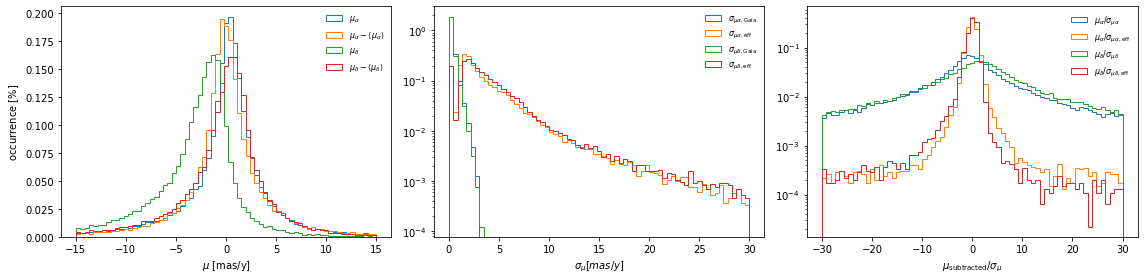

In [54]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

xmax, nbins = 15, 70
ax[0].hist(stars_df['pmra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmra_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['pmdec_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\mu_\alpha$', r'$\mu_\alpha - \langle \mu_\alpha \rangle$', '$\mu_\delta$', r'$\mu_\delta - \langle \mu_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 30, 70
ax[1].hist(stars_df['pmra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmra_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['pmdec_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\mu\alpha, \mathrm{Gaia}}$', r'$\sigma_{\mu\alpha, \mathrm{eff}}$', r'$\sigma_{\mu\delta, \mathrm{Gaia}}$', r'$\sigma_{\mu\delta, \mathrm{eff}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\mu [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 30, 70
ax[2].hist(stars_df['pmra_sub']/stars_df['pmra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmra_sub']/stars_df['pmra_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub']/stars_df['pmdec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['pmdec_sub']/stars_df['pmdec_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\mu_{\alpha}/\sigma_{\mu\alpha}$', r'$\mu_{\alpha}/\sigma_{\mu\alpha, \mathrm{eff}}$', 
              r'$\mu_{\delta}/\sigma_{\mu\delta}$', r'$\mu_{\delta}/\sigma_{\mu\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel(r'occurrence [$\%$]');

plt.tight_layout()
fig.savefig(FigDir+'pm_stats.pdf')

In [55]:
print('\nProper motion plots have been made.'); sys.stdout.flush()


Proper motion plots have been made.


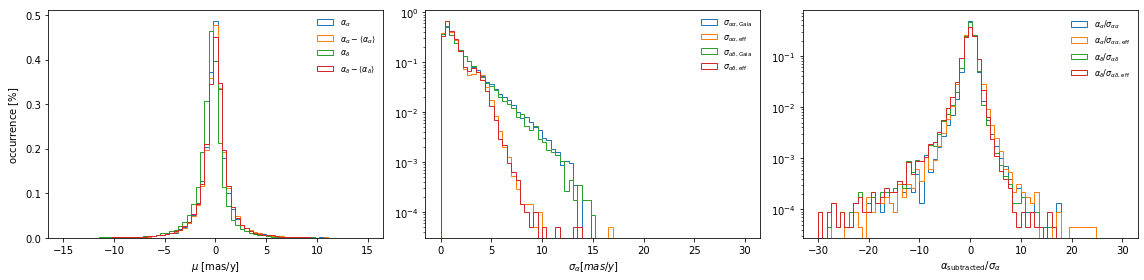

In [56]:
fig,ax = plt.subplots(1,3,figsize=(16,4))

xmax, nbins = 15, 70
ax[0].hist(stars_df['acc_ra'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['acc_ra_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['acc_dec'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].hist(stars_df['acc_dec_sub'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[0].legend([r'$\alpha_\alpha$', r'$\alpha_\alpha - \langle \alpha_\alpha \rangle$', r'$\alpha_\delta$', r'$\alpha_\delta - \langle \alpha_\delta \rangle$'], loc='upper right', fontsize = 8, frameon=False);
ax[0].set_xlabel(r'$\mu$ [mas/y]'); ax[0].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 30, 70
ax[1].hist(stars_df['acc_ra_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['acc_ra_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['acc_dec_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['acc_dec_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\alpha\alpha, \mathrm{Gaia}}$', r'$\sigma_{\alpha\alpha, \mathrm{eff}}$', r'$\sigma_{\alpha\delta, \mathrm{Gaia}}$', r'$\sigma_{\alpha\delta, \mathrm{eff}}$'], 
             loc='upper right', fontsize = 8, frameon=False);
ax[1].set_xlabel(r'$\sigma_\alpha [mas/y]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 30, 70
ax[2].hist(stars_df['acc_ra_sub']/stars_df['acc_ra_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['acc_ra_sub']/stars_df['acc_ra_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['acc_dec_sub']/stars_df['acc_dec_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].hist(stars_df['acc_dec_sub']/stars_df['acc_dec_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=True, density=True, histtype='step');
ax[2].legend([r'$\alpha_{\alpha}/\sigma_{\alpha\alpha}$', r'$\alpha_{\alpha}/\sigma_{\alpha\alpha, \mathrm{eff}}$', 
              r'$\alpha_{\delta}/\sigma_{\alpha\delta}$', r'$\alpha_{\delta}/\sigma_{\alpha\delta, \mathrm{eff}}$'], loc='upper right', fontsize = 8, frameon=False);
ax[2].set_xlabel(r'$\alpha_\mathrm{subtracted}/\sigma_\alpha$'); #ax[2].set_ylabel(r'occurrence [$\%$]');


plt.tight_layout()
fig.savefig(FigDir+'accel_stats.pdf')

In [57]:
print('\nAcceleration plots have been made.'); sys.stdout.flush()


Acceleration plots have been made.


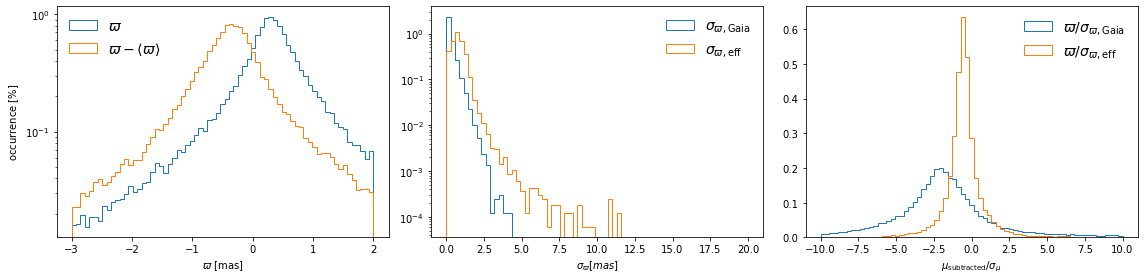

In [58]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
font_size = 14

xmin, xmax, nbins = -3, 2, 70
ax[0].hist(stars_df['parallax'], bins=np.linspace(xmin, xmax, nbins), log=True, density=True, histtype='step');
ax[0].hist(stars_df['parallax_sub'], bins=np.linspace(xmin, xmax, nbins), log=True, density=True, histtype='step');
ax[0].legend([r'$\varpi$', r'$\varpi - \langle \varpi \rangle$'], loc='upper left', fontsize = font_size, frameon=False);
ax[0].set_xlabel(r'$\varpi$ [mas]'); ax[0].set_ylabel(r'occurrence [$\%$]');
#ax.set_title(r'Velocity template for '+str(len(tau_list[map_count>min_count]))+' subsets', fontsize = 16);

xmax, nbins = 20, 70
ax[1].hist(stars_df['parallax_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].hist(stars_df['parallax_eff_error'], bins=np.linspace(0, xmax, nbins), log=True, density=True, histtype='step');
ax[1].legend([r'$\sigma_{\varpi, \mathrm{Gaia}}$', r'$\sigma_{\varpi, \mathrm{eff}}$'], loc='upper right', fontsize = font_size, frameon=False);
ax[1].set_xlabel(r'$\sigma_\varpi [mas]$'); #ax[1].set_ylabel(r'occurrence [$\%$]');

xmax, nbins = 10, 70
ax[2].hist(stars_df['parallax_sub']/stars_df['parallax_error'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[2].hist(stars_df['parallax_sub']/stars_df['parallax_eff_error'], bins=np.linspace(-xmax, xmax, nbins), log=False, density=True, histtype='step');
ax[2].legend([r'$\varpi/\sigma_{\varpi, \mathrm{Gaia}}$', r'$\varpi/\sigma_{\varpi, \mathrm{eff}}$'], loc='upper right', fontsize = font_size, frameon=False);
ax[2].set_xlabel(r'$\mu_\mathrm{subtracted}/\sigma_\mu$'); #ax[2].set_ylabel('occurrence [%]');

plt.tight_layout()
fig.savefig(FigDir+'par_stats.pdf')

In [59]:
print('\nParallax plots have been made.'); sys.stdout.flush()


Parallax plots have been made.
